# A Basic Model
In this example application it is shown how a simple time series model can be developed to simulate groundwater levels. The recharge (calculated as preciptation minus evaporation) is used as the explanatory time series.

In [1]:
# First perform the necessary imports
import pandas as pd
import matplotlib.dates as md
import matplotlib.pyplot as plt
from pasta import *
%matplotlib notebook

### 1. Importing the dependent time series data
In this codeblock a time series of groundwater levels is imported using pandas `read_csv` function. These are the groundwater levels observed in a well in The Netherlands (ID B58C0698001). As PASTA expects a pandas Series object, a single column is selected from the pandas DataFrame (`gwdata`). To check if you have the correct data type (a Pandas Series object), you can use `type(oseries)` as is done in this example. 

The following characteristics are important when importing and preparing the observed time series:
- The observed time series are stored as a Pandas time series object.
- All lines must contain a value, nan must be dropped.
- The time step can be irregular, this is no problem for PASTA.

The data type of the oseries is: <class 'pandas.core.series.Series'>


<IPython.core.display.Javascript object>


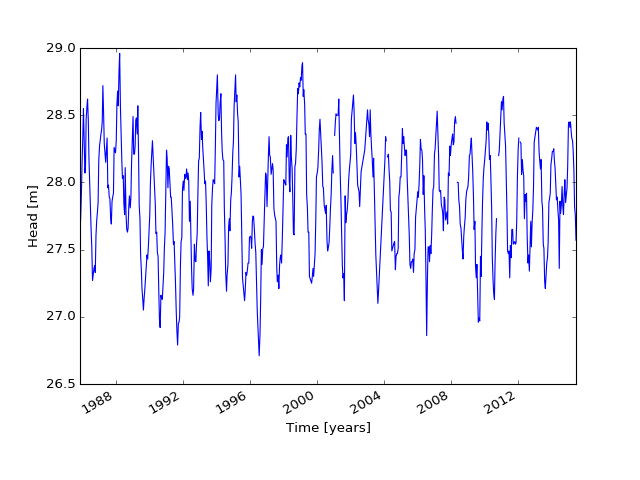

In [2]:
# Import and check the observed groundwater time series
gwdata = pd.read_csv('../data/B58C0698001_0.csv', skiprows=11, 
                     parse_dates=['PEIL DATUM TIJD'], index_col='PEIL DATUM TIJD', 
                     skipinitialspace=True)
gwdata.rename(columns={'STAND (MV)': 'h'}, inplace=True)
gwdata.index.names = ['date']
gwdata.h *= 0.01
oseries = 30.17 - gwdata.h  # Change the reference  (NAP)
print('The data type of the oseries is: %s' %type(oseries))

# Plot the observed groundwater levels
plt.figure()
oseries.plot()
plt.ylabel('Head [m]');
plt.xlabel('Time [years]');
plt.show()

### 2. Import the independent time series
Let's try to explain the fluctuations in the groundwater levels with two independent time series: the precipitation and the potential evaporation. As is the case with the observed series, PASTA expects pandas Series object for all time series. 

Important characteristics of these time series are:
- Same units as the observed time series
- Values are necessary on every time step
- The time series should be stored as Pandas Time Series

The data type of the precip series is: <class 'pandas.core.series.Series'>
The data type of the evap series is: <class 'pandas.core.series.Series'>
The data type of the recharge series is: <class 'pandas.core.series.Series'>


<IPython.core.display.Javascript object>


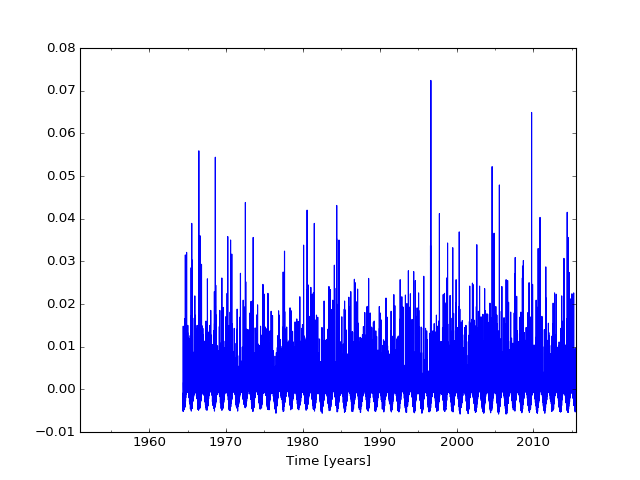

In [3]:
# Import observed precipitation series
precip = pd.read_csv('../data/Heibloem_rain_data.dat', skiprows=4,
                     delim_whitespace=True, parse_dates=['date'], 
                     index_col='date')
precip = precip.precip
precip /= 1000.0  # Meters
print('The data type of the precip series is: %s' %type(precip))

# Import observed evaporation series
evap = pd.read_csv('../data/Maastricht_E_June2015.csv', skiprows=4, 
                   sep=';', parse_dates=['DATE'], index_col='DATE')
evap.rename(columns={'VALUE (m-ref)': 'evap'}, inplace=True)
evap = evap.evap
print('The data type of the evap series is: %s' %type(evap))

# Calculate the recharge to the groundwater

recharge = precip - evap
print('The data type of the recharge series is: %s' %type(recharge))

# Plot the time series of the precipitation and evaporation
plt.figure()
recharge.plot(label='Recharge')
plt.xlabel('Time [years]')
plt.show()

### 3. Creating the time series model
In this code block the actual time series model is created. First, an instance of the Model class is created (named `ml` here). Second, the different components of the time series model are created and added to the model. The imported time series are automatically checked for missing values and other inconsistencies. The keyword argument fillnan can be used to determine how missing values are handled. If any nan-values are found this will be reported by PASTA.

In [4]:
# Initiate the base model
ml = Model(oseries)

# Add the recharge data as explanatory variable
ts1 = Tseries(recharge, Gamma, name='recharge', fillnan='mean')
ml.add_tseries(ts1)

# Add a constant
d = Constant(value=oseries.mean())
ml.add_tseries(d)

# Add a noisemodel
n = NoiseModel()
ml.add_noisemodel(n)

6 nan-value(s) in the oseries was/were found and handled/filled with: drop
Inferred frequency from time series recharge: freq=D 


### 4. Solving and plotting the model
The next and final step is to optimize the model parameters. By default a non-linear least squares method is used for the optimization. The python package LMFIT is used for this (https://github.com/lmfit/lmfit-py). Some standard optimization statistics are reported along with the optimized parameter values and correlations.

In [5]:
# Solve the time series model
ml.solve()

[[Fit Statistics]]
    # function evals   = 39
    # data points      = 644
    # variables        = 5
    chi-square         = 4.236
    reduced chi-square = 0.007
    Akaike info crit   = -3225.510
    Bayesian info crit = -3203.172
[[Variables]]
    recharge_A:    717.653989 +/- 32.21796 (4.49%) (init= 500)
    recharge_n:    1.06116288 +/- 0.016088 (1.52%) (init= 1)
    recharge_a:    127.192519 +/- 7.486140 (5.89%) (init= 100)
    constant_d:    27.5732316 +/- 0.018557 (0.07%) (init= 27.90008)
    noise_alpha:   57.0604321 +/- 7.329838 (12.85%) (init= 14)
[[Correlations]] (unreported correlations are <  0.100)
    C(recharge_A, recharge_a)    =  0.834 
    C(recharge_A, constant_d)    = -0.769 
    C(recharge_n, recharge_a)    = -0.650 
    C(recharge_a, constant_d)    = -0.646 
    C(recharge_A, recharge_n)    = -0.260 
    C(recharge_n, constant_d)    =  0.212 


<IPython.core.display.Javascript object>


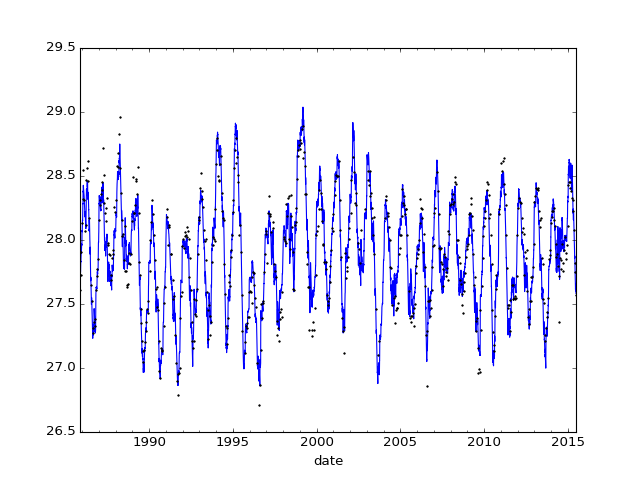

In [6]:
ml.plot()
plt.show()

## 6. Advanced plotting
There are many ways to further explore the time series model we have just calibrated (the power of Python is at your fingertips). However, PASTA has some built-in functionalities that will provide the user with a first quick overview of the model. One of these is the method `plot_results` which provides a plot with more information.

<IPython.core.display.Javascript object>


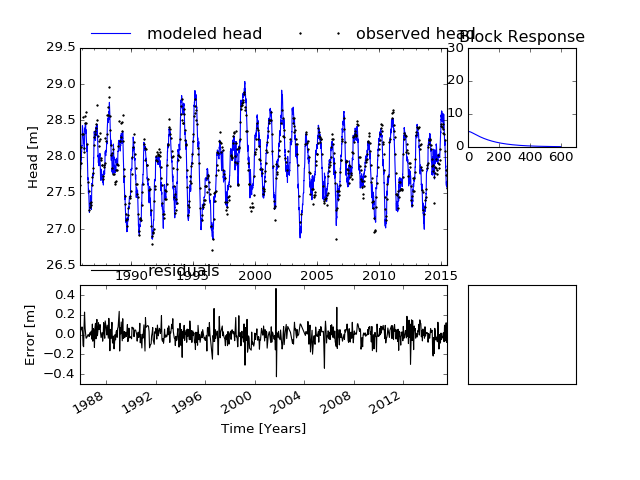

In [7]:
ml.plot_results() 

In [8]:
ml.stats.summary()

                                    Value
Statistic                                
Average Deviation               -0.000151
Bayesian Information Criterion  29.450441
Pearson R^2                      0.957375
Explained variance percentage   91.640202
Akaike InformationCriterion      7.111948
Root mean squared error          0.124275
